## MAPK model testing notebook
*Nathaniel Linden - September 2023*

We will use this notebook to test each of the MAPK models by attempting to recreate a figure from their original papers

In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode

sys.path.append("./models/")
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from vonKriegsheim_2009_Rap1 import *
from shin_2014_Rap1 import *
from ryu_2015_Rap1 import *
from kochanczyk_2017 import *



jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *


## Helper functions
First we define a few help functions that will be used throughout the notebook.
They functions simulate a trajectory, and a steady-state.

In [2]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3
    times = np.linspace(t0, t1, n_out)
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=600000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


## Orton 2009

In [6]:
OR_2009 = orton_2009(transient=False)
pdict, plist = OR_2009.get_nominal_params()
y0_dict, y0 = OR_2009.get_initial_conditions()

y0_dict['EGF'] = y0_dict['EGF'] 
y0 = tuple([y0_dict[k] for k in y0_dict.keys()])

sol = simulate_model_trajectory(OR_2009, y0, plist, t1=60)

# Rap 1 KD
y0_dict['EGF'] = y0_dict['EGF']
y0_dict['Rap1Inactive'] = 0.0
y0 = tuple([y0_dict[k] for k in y0_dict.keys()])

sol_rap1_KD = simulate_model_trajectory(OR_2009, y0, plist, t1=60)

15
15


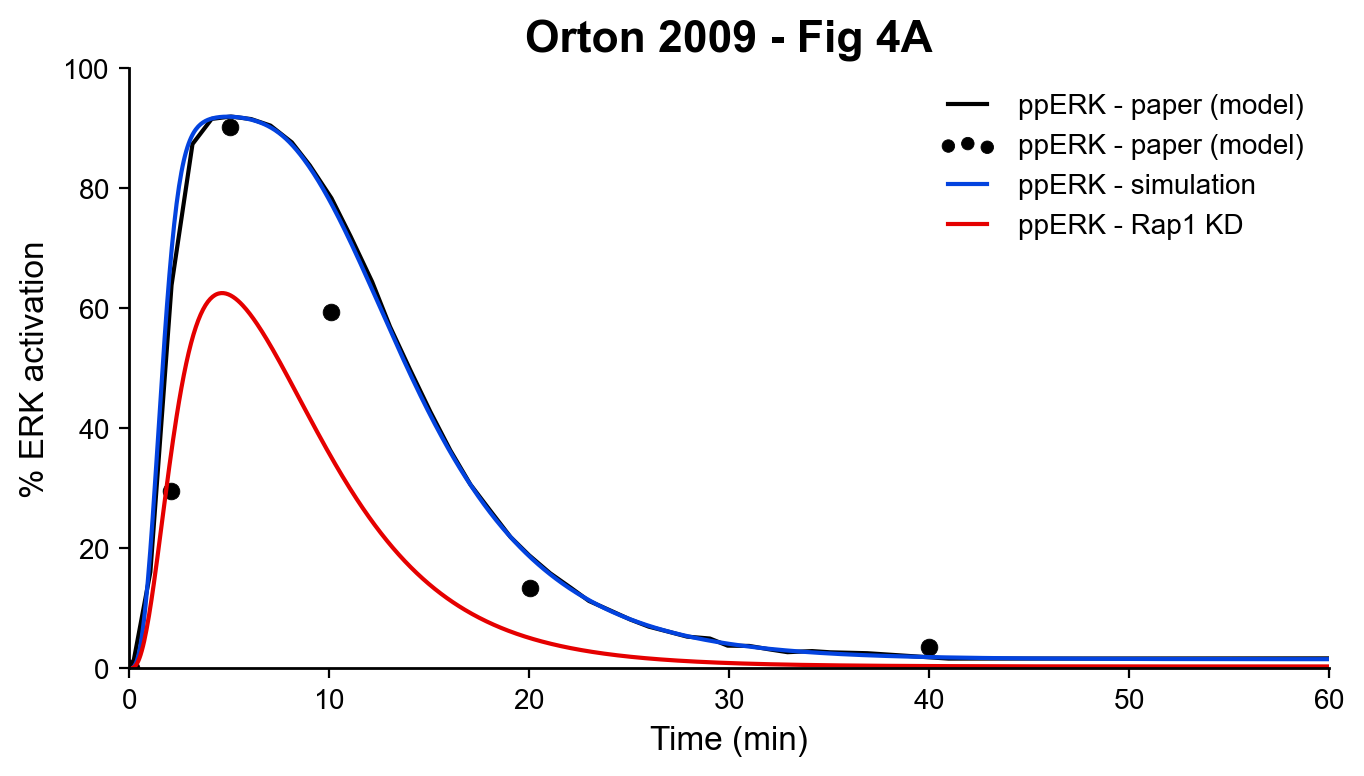

In [7]:
# load data
OR_2009_fig4A_model = pd.read_csv('./paper_data/orton_2009_fig4A_model.csv').to_numpy()
OR_2009_fig4A_data = pd.read_csv('./paper_data/orton_2009_fig4A_data.csv').to_numpy()

fig, ax  = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/O_2009_fig4A'
ax.plot(OR_2009_fig4A_model[:, 0], (OR_2009_fig4A_model[:, 1]/y0_dict['ErkInactive'])*100, '-', color='k', label='ppERK - paper (model)')
ax.scatter(OR_2009_fig4A_data[:, 0], (OR_2009_fig4A_data[:, 1]/y0_dict['ErkInactive'])*100, color='k', label='ppERK - paper (model)')

ERKActive_idx = list(y0_dict.keys()).index('ErkActive')
print(ERKActive_idx)
print(ERKActive_idx)
ax.plot(sol.ts, (sol.ys[ERKActive_idx]/y0_dict['ErkInactive'])*100, '-', color='xkcd:blue', label='ppERK - simulation')
ax.plot(sol_rap1_KD.ts, (sol_rap1_KD.ys[ERKActive_idx]/y0_dict['ErkInactive'])*100, '-', color='xkcd:red', label='ppERK - Rap1 KD')

ax.set_title('Orton 2009 - Fig 4A')
ax.set_xlabel('Time (min)')
ax.set_ylabel('% ERK activation')
ax.set_xlim([0, 60])
ax.set_ylim([0, 100])

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

## von Kriegsheim 2009

In [16]:
VK_2009 = vonKriegsheim_2009()
pdict, plist = VK_2009.get_nominal_params()
y0_dict, y0 = VK_2009.get_initial_conditions()

y0_dict['EGF'] = 100

y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
sol_egf20 = simulate_model_trajectory(VK_2009, y0, plist, t1=1800)

# y0_dict['EGF'] = 0.0
# y0_dict['NGF'] = 100.0 
# y0_dict['NGFR'] = 1.0
# y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
# sol_ngf100 = simulate_model_trajectory(VK_2009, y0, plist, t1=1800)

22 24 25


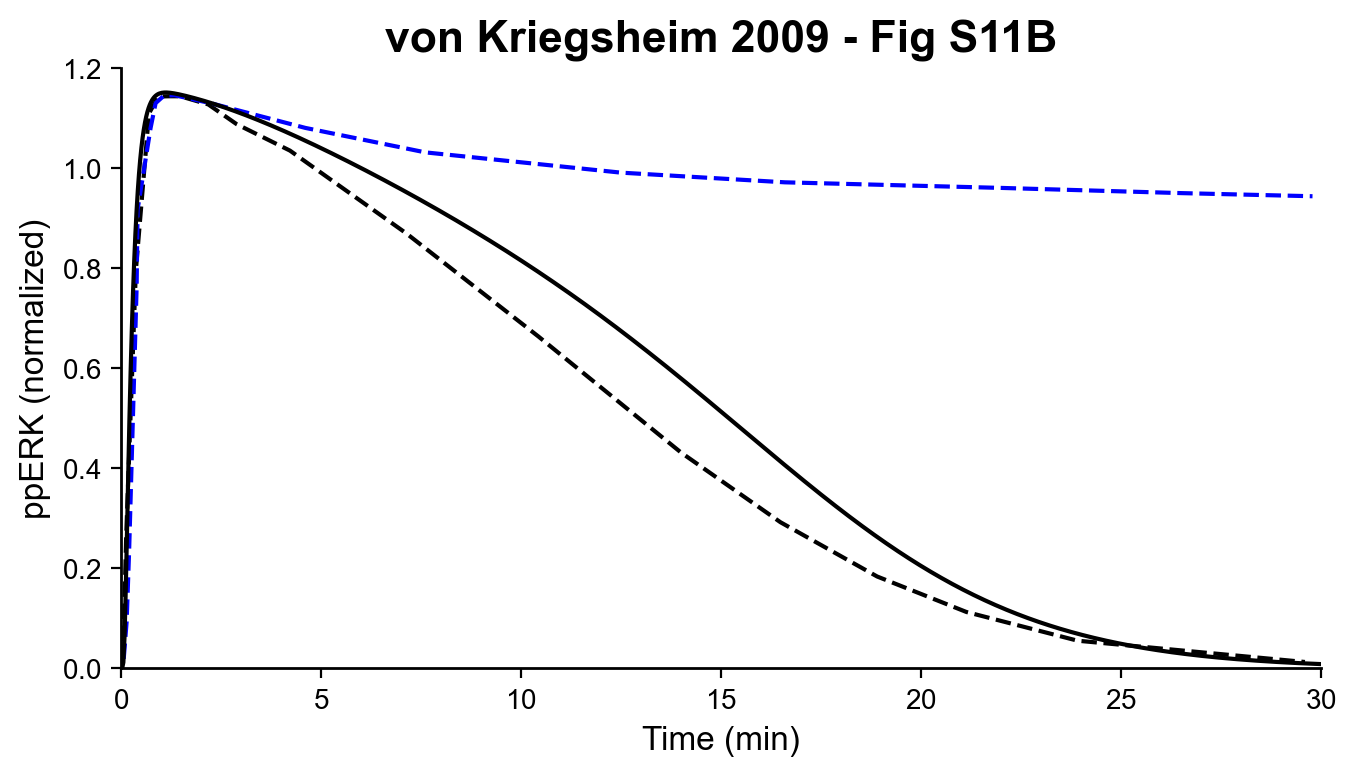

In [17]:
# load figure simulations
VK_2009_figS11B_egf20 = pd.read_csv('./paper_data/vonKriegsheim_2009_figS11B_20egf.csv').to_numpy()
VK_2009_figS11B_ngf100 = pd.read_csv('./paper_data/vonKriegsheim_2009_figS11B_100ngf.csv').to_numpy()

ppERK_idx = list(y0_dict.keys()).index('ppERK')
ppERK_15_idx = list(y0_dict.keys()).index('ppERK_15')
ppERKn_idx = list(y0_dict.keys()).index('ppERKn')

print(ppERK_idx, ppERK_15_idx, ppERKn_idx)

fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/VK_2009_figS11B'

norm = 0.701412355126078
egf_egf20 = (sol_egf20.ys[ppERK_idx]/norm) + \
            (sol_egf20.ys[ppERK_15_idx]/norm) + \
            ((sol_egf20.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])

# egf_ngf100 = (sol_ngf100.ys[ppERK_idx]/norm) + \
#             (sol_ngf100.ys[ppERK_15_idx]/norm) + \
#             ((sol_ngf100.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])

ax.plot(VK_2009_figS11B_egf20[:, 0], VK_2009_figS11B_egf20[:, 1], '--', color='k', label='EGF=20 - paper')
ax.plot(VK_2009_figS11B_ngf100[:, 0], VK_2009_figS11B_ngf100[:, 1], '--', color='b', label='NGF=100 - paper')
ax.plot(sol_egf20.ts/60, egf_egf20, '-', color='k', label='EGF=20')
# ax.plot(sol_ngf100.ts//60, egf_ngf100, '-', color='b', label='NGF=100')

ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 1.2])
ax.set_title('von Kriegsheim 2009 - Fig S11B')

leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

Effect of Rap1 and Rap1 KD

In [20]:
VK_2009_rap1 = vonKriegsheim_2009_Rap1()
pdict, plist = VK_2009_rap1.get_nominal_params()
y0_dict, y0 = VK_2009_rap1.get_initial_conditions()

y0_dict['EGF'] = 100

y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
sol_egf_rap1 = simulate_model_trajectory(VK_2009_rap1, y0, plist, t1=1800)

y0_dict['Rap1'] = 0.0

y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
sol_egf_rap1_KD = simulate_model_trajectory(VK_2009_rap1, y0, plist, t1=1800)

22 24 25


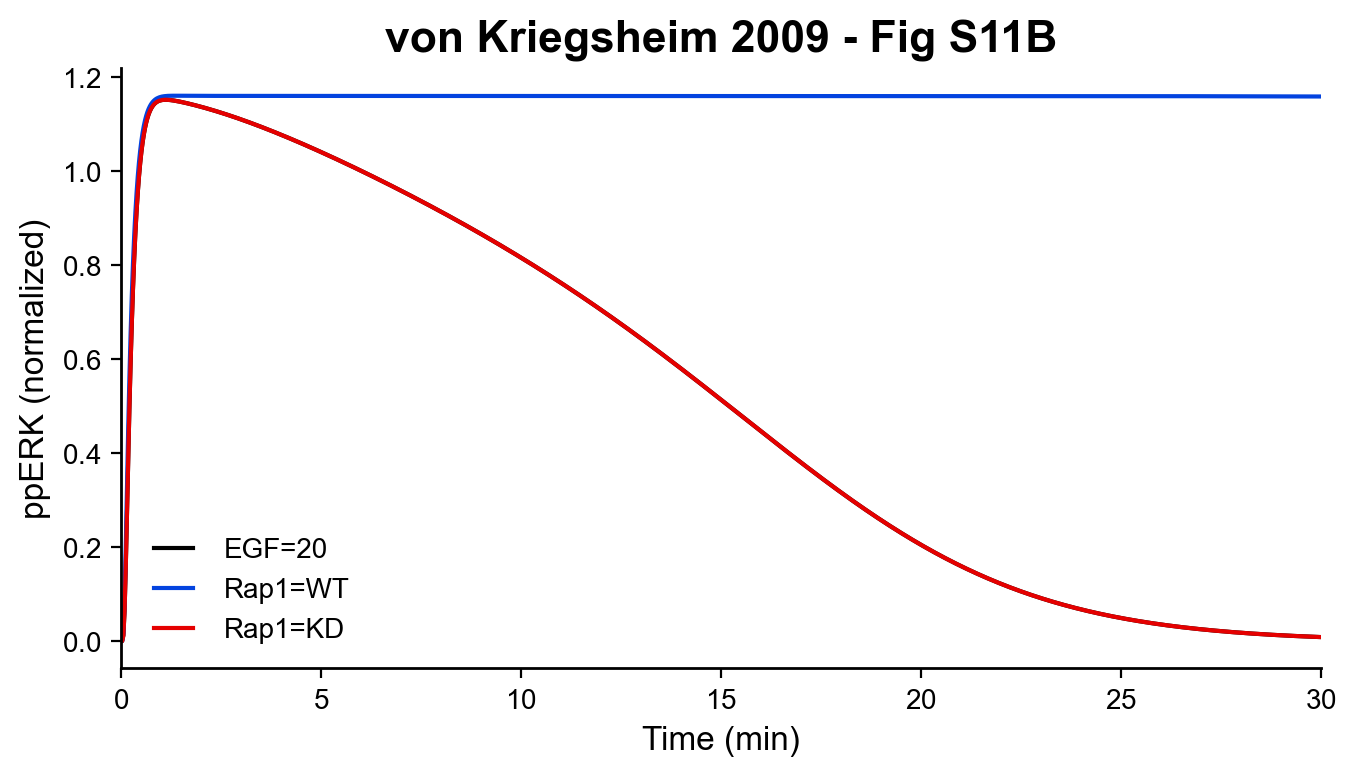

In [21]:
# load figure simulations
VK_2009_figS11B_egf20 = pd.read_csv('./paper_data/vonKriegsheim_2009_figS11B_20egf.csv').to_numpy()
VK_2009_figS11B_ngf100 = pd.read_csv('./paper_data/vonKriegsheim_2009_figS11B_100ngf.csv').to_numpy()

ppERK_idx = list(y0_dict.keys()).index('ppERK')
ppERK_15_idx = list(y0_dict.keys()).index('ppERK_15')
ppERKn_idx = list(y0_dict.keys()).index('ppERKn')

print(ppERK_idx, ppERK_15_idx, ppERKn_idx)

fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/VK_2009_figS11B'

norm = 0.701412355126078
egf_egf20 = (sol_egf20.ys[ppERK_idx]/norm) + \
            (sol_egf20.ys[ppERK_15_idx]/norm) + \
            ((sol_egf20.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])

egf_rap1 = (sol_egf_rap1.ys[ppERK_idx]/norm) + \
            (sol_egf_rap1.ys[ppERK_15_idx]/norm) + \
            ((sol_egf_rap1.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])  

egf_rap1_KD = (sol_egf_rap1_KD.ys[ppERK_idx]/norm) + \
            (sol_egf_rap1_KD.ys[ppERK_15_idx]/norm) + \
            ((sol_egf_rap1_KD.ys[ppERKn_idx]/norm)*pdict['V_NUC']/pdict['V_CYT'])



ax.plot(sol_egf20.ts/60, egf_egf20, '-', color='k', label='EGF=20')
ax.plot(sol_egf_rap1.ts/60, egf_rap1, '-', color='xkcd:blue', label='Rap1=WT')
ax.plot(sol_egf_rap1_KD.ts/60, egf_rap1_KD, '-', color='xkcd:red', label='Rap1=KD')
# ax.plot(sol_ngf100.ts//60, egf_ngf100, '-', color='b', label='NGF=100')

ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
ax.set_xlim([0, 30])
ax.set_title('von Kriegsheim 2009 - Fig S11B')

leg = ax.legend(fontsize=10)

## Shin 2014

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_36860/1982116993.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_36860/1982116993.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_36860/1982116993.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument

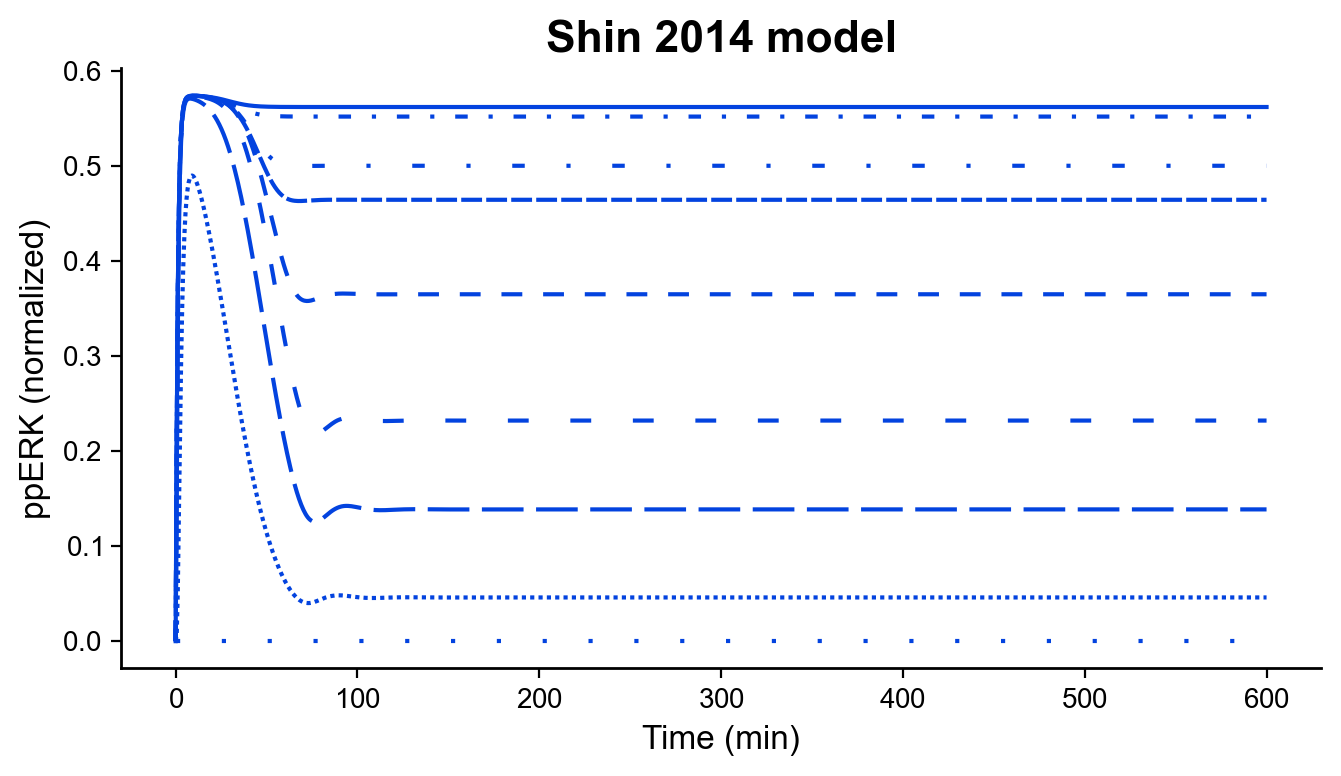

In [3]:
SN_2014 = shin_2014(transient=False)
pdict, plist = SN_2014.get_nominal_params()
y0_dict, y0 = SN_2014.get_initial_conditions()

sols = {}
cols = ['xkcd:blue', 'xkcd:black', 'xkcd:indigo', 'xkcd:red', 'xkcd:gray', 'xkcd:brown', 'xkcd:pink', 'xkcd:gray', 'xkcd:dark yellow']

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     # ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     # ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('', '-'),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

EGFs = [0, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]
fig, ax = get_sized_fig_ax(6.0, 3.0)
fname = '../../figures/MAPK/validation/S_2014'
for i, EGF in enumerate(EGFs):
    y0_dict['EGF'] = EGF
    y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
    sol = simulate_model_trajectory(SN_2014, y0, plist, t1=600)
    sols[EGF] = sol

    ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
ax.set_title('Shin 2014 model')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
leg = ax.legend(fontsize=10, ncol=3)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

Effect of Rap1 and Rap1 KD

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_36860/3402827240.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_36860/3402827240.py:40: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol_Rap1.ts, sol_Rap1.ys[-3]/pdict['ERK_tot'], '-', color='k', label='EGF={} uM - Rap1'.format(EGF), linestyle=linestyle_tuple[i][1])
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_36860/3402827240.py:41: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword

Text(0, 0.5, 'ppERK (normalized)')

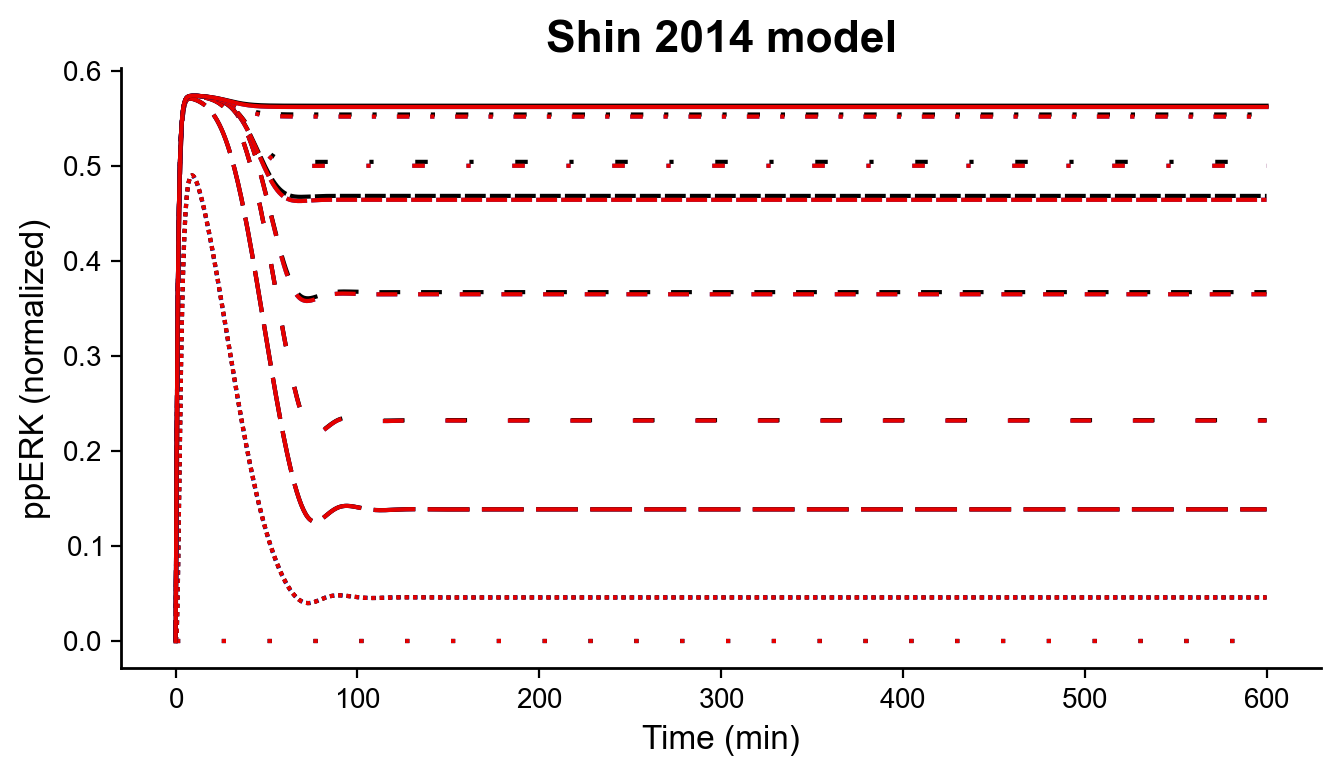

In [6]:
SN_2014_rap1 = shin_2014_Rap1(transient=False)
pdict_Rap1, plist_Rap1 = SN_2014_rap1.get_nominal_params()
y0_dict_Rap1, y0_Rap1 = SN_2014_rap1.get_initial_conditions()

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     # ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     # ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('', '-'),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

EGFs = [0, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]
fig, ax = get_sized_fig_ax(6.0, 3.0)

for i, EGF in enumerate(EGFs):
    y0_dict['EGF'] = EGF
    y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
    sol = simulate_model_trajectory(SN_2014, y0, plist, t1=600)
    
    y0_dict_Rap1['Rap1'] = 100.0
    y0_dict_Rap1['EGF'] = EGF
    y0_Rap1 = tuple([y0_dict_Rap1[key] for key in y0_dict_Rap1.keys()])
    sol_Rap1 = simulate_model_trajectory(SN_2014_rap1, y0_Rap1, plist_Rap1, t1=600)

    y0_dict_Rap1['Rap1'] = 0.0
    y0_Rap1 = tuple([y0_dict_Rap1[key] for key in y0_dict_Rap1.keys()])
    sol_Rap1_KD = simulate_model_trajectory(SN_2014_rap1, y0_Rap1, plist_Rap1, t1=600)

    ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
    ax.plot(sol_Rap1.ts, sol_Rap1.ys[-3]/pdict['ERK_tot'], '-', color='k', label='EGF={} uM - Rap1'.format(EGF), linestyle=linestyle_tuple[i][1])
    ax.plot(sol_Rap1_KD.ts, sol_Rap1_KD.ys[-3]/pdict['ERK_tot'], '-', color='xkcd:red', label='EGF={} uM - Rap1 KD'.format(EGF), linestyle=linestyle_tuple[i][1])

ax.set_title('Shin 2014 model')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
# leg = ax.legend(fontsize=10, ncol=3)



## Ryu 2015

In [11]:
R_2015 = ryu_2015()
pdict, plist = R_2015.get_nominal_params()
y0_dict, y0 = R_2015.get_initial_conditions()

R_2015_rap1 = ryu_2015_Rap1()
pdict_rap1, plist_rap1 = R_2015_rap1.get_nominal_params()
y0_dict_rap1, y0_rap1 = R_2015_rap1.get_initial_conditions()

Rap1 = 1.0

sols = []
sols_Rap1 = []
sols_Rap1_KD = []
EGFs = [1.0, 100.0]
for EGF in EGFs:
    y0_dict['EGF'] = EGF
    y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
    sol = simulate_model_trajectory(R_2015, y0, plist, t1=60)
    sols.append(sol)

    # run rap1 model
    y0_dict_rap1['EGF'] = EGF
    y0_dict_rap1['Rap1'] = Rap1
    y0 = tuple([y0_dict_rap1[key] for key in y0_dict_rap1.keys()])
    sol = simulate_model_trajectory(R_2015_rap1, y0, plist_rap1, t1=60)
    sols_Rap1.append(sol)

    y0_dict_rap1['Rap1'] = 0.0
    y0 = tuple([y0_dict_rap1[key] for key in y0_dict_rap1.keys()])
    sol = simulate_model_trajectory(R_2015_rap1, y0, plist_rap1, t1=60)
    sols_Rap1_KD.append(sol)

# load data
R_2015_fig5B_egfLOW = pd.read_csv('./paper_data/ryu_2015_fig5B_egfLOW.csv').to_numpy()
R_2015_fig5B_egfHIGH = pd.read_csv('./paper_data/ryu_2015_fig5B_egfHIGH.csv').to_numpy()
R_2015_fig5B_ngfLOW = pd.read_csv('./paper_data/ryu_2015_fig5B_ngfLOW.csv').to_numpy()
R_2015_fig5B_ngfHIGH = pd.read_csv('./paper_data/ryu_2015_fig5B_ngfHIGH.csv').to_numpy()

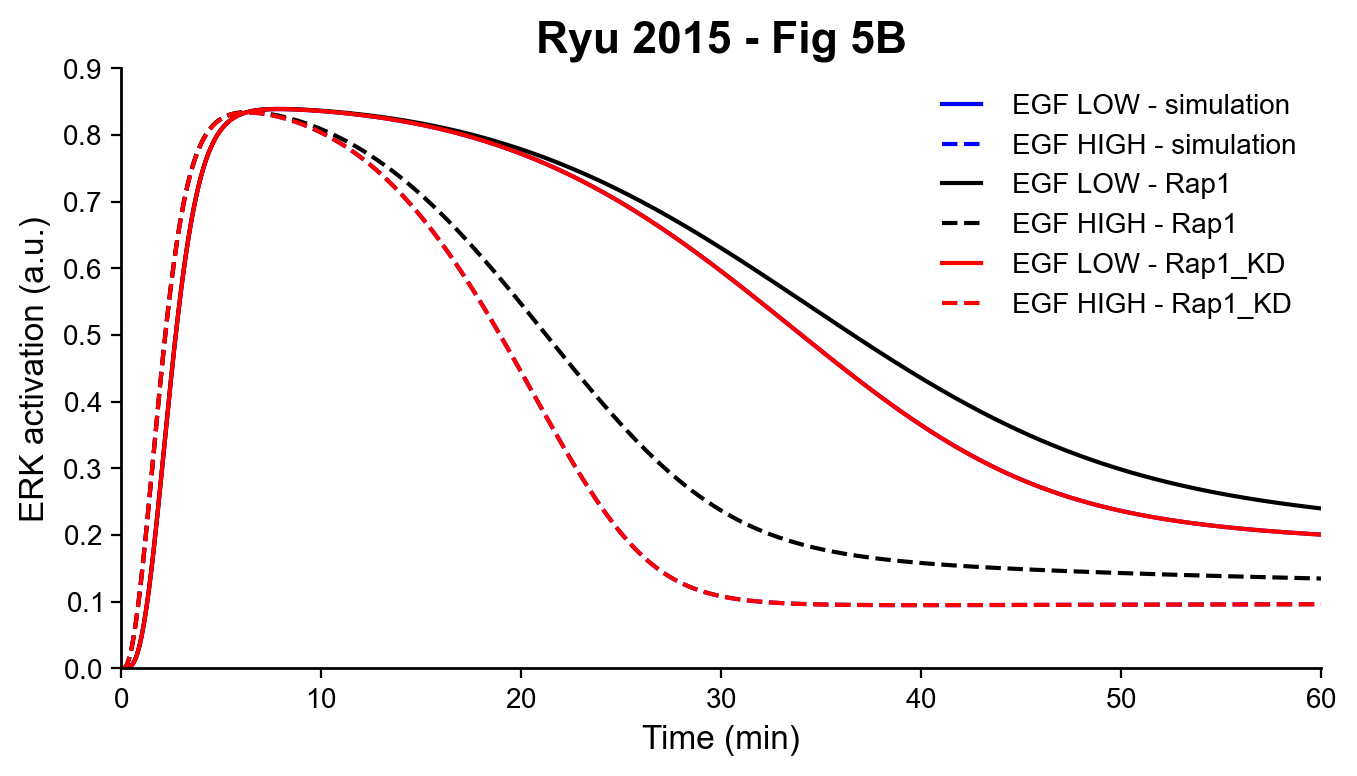

In [16]:
# low
fig, ax = get_sized_fig_ax(6.0, 3.0)
ERK_star_idx = list(y0_dict.keys()).index('ERK_star')
ax.plot(sols[0].ts, sols[0].ys[ERK_star_idx], '-', color='b', label='EGF LOW - simulation')
ax.plot(sols[1].ts, sols[1].ys[ERK_star_idx], '--', color='b', label='EGF HIGH - simulation')

ax.plot(sols_Rap1[0].ts, sols_Rap1[0].ys[ERK_star_idx], '-', color='k', label='EGF LOW - Rap1')
ax.plot(sols_Rap1[1].ts, sols_Rap1[1].ys[ERK_star_idx], '--', color='k', label='EGF HIGH - Rap1')

ax.plot(sols_Rap1_KD[0].ts, sols_Rap1_KD[0].ys[ERK_star_idx], '-', color='r', label='EGF LOW - Rap1_KD')
ax.plot(sols_Rap1_KD[1].ts, sols_Rap1_KD[1].ys[ERK_star_idx], '--', color='r', label='EGF HIGH - Rap1_KD')


ax.set_title('Ryu 2015 - Fig 5B')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ERK activation (a.u.)')
ax.set_xlim([0.0, 60.0])
ax.set_ylim([0.0, 0.9])

leg = ax.legend(fontsize=10)


## Kochanczyk 2017 - TBD

In [55]:
K_2017 = kochanczyk_2017()
pdict, plist = K_2017.get_nominal_params()
y0_dict, y0 = K_2017.get_initial_conditions()

tmax = 24*60*60
EGFs = [2.6, 20.0, 200.0] # egf concentrations in pg/mL
sols = {}
for EGF in EGFs:
    y0_dict, y0 = K_2017.get_initial_conditions()
    y0_dict['EGF'] = EGF
    y0 = tuple([y0_dict[key] for key in y0_dict.keys()])
    sol = simulate_model_trajectory(K_2017, y0, plist, t1=tmax)
    sols[EGF] = sol

# import data from bionetgen sims in the paper
K_2017_fig4A = np.load('./paper_data/Kochanczyk_fig4A.npy')
K_2017_fig4B = np.load('./paper_data/Kochanczyk_fig4B.npy')
K_2017_fig4C = np.load('./paper_data/Kochanczyk_fig4C.npy')

24


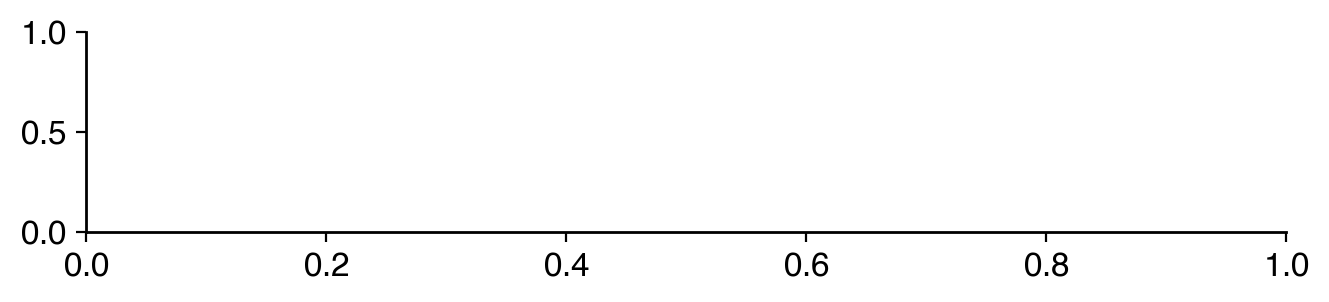

In [56]:
fig, ax = get_sized_fig_ax(6.0, 1.0)
fname = '../../figures/MAPK/validation/K_2017_fig4A'

ppERK_idx = list(y0_dict.keys()).index('ERKSPP')

ax.plot(K_2017_fig4A[0, :]/3600, K_2017_fig4A[1, :]/y0_dict['ERKSU'], '-', color='k', label='EGF=2.6 pg/mL - paper')
ax.plot(sols[2.6].ts/3600, sols[2.6].ys[ppERK_idx]/y0_dict['ERKSU'], '--', color='b', label='EGF=2.6 pg/mL - simulation')
ax.set_xlim([0, 24])
ax.set_ylim([0, 1.0])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('ppERK \n (normalized)')
ax.set_title('Kochanczyk 2017 - Fig 4A')
leg = ax.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

fig1, ax1 = get_sized_fig_ax(6.0, 1.0)
fname = '../../figures/MAPK/validation/K_2017_fig4B'

ax1.plot(K_2017_fig4B[0, :]/3600, K_2017_fig4B[1, :]/y0_dict['ERKSU'], '-', color='k', label='EGF=20 pg/mL - paper')
ax1.plot(sols[20].ts/3600, sols[20].ys[ppERK_idx]/y0_dict['ERKSU'], '--', color='b', label='EGF=20 pg/mL - simulation')
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1.0])
ax1.set_xlabel('Time (hr)')
ax1.set_ylabel('ppERK \n (normalized)')
ax1.set_title('Kochanczyk 2017 - Fig 4B')
leg = ax1.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig1.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)

fig2, ax2 = get_sized_fig_ax(6.0, 1.0)
fname = '../../figures/MAPK/validation/K_2017_fig4C'

ax2.plot(K_2017_fig4C[0, :]/3600, K_2017_fig4C[1, :]/y0_dict['ERKSU'], '-', color='k', label='EGF=200 pg/mL - paper')
ax2.plot(sols[200].ts/3600, sols[200].ys[ppERK_idx]/y0_dict['ERKSU'], '--', color='b', label='EGF=200 pg/mL - simulation')
ax2.set_xlim([0, 24])
ax2.set_ylim([0, 1.0])
ax2.set_xlabel('Time (hr)')
ax2.set_ylabel('ppERK \n (normalized)')
ax2.set_title('Kochanczyk 2017 - Fig 4C')
leg = ax2.legend(fontsize=10)
export_legend(leg, filename=fname+'_legend.pdf')
leg.remove()

fig2.savefig(fname+'_fig.pdf', bbox_inches='tight', transparent=True)